## Use ridge regression to model polynomial 15th degree

Can a more complex model with regularization get better performance?

Best parameters: {'Ridge__alpha': 0.8, 'features__num_vars__poly__degree': 15}
test R squared: 0.5341188733560205

Results:
At poly 15, adding L2 regularization adds a tiny increase in  $R^2$ . The best Ridge alpha was again 0.8 with $R^2$  of 0.5341, essentially the same as OLS.

It may be the case that if we increase to poly degree 16, we can do better.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 8))
np.set_printoptions(precision=4, suppress=False)
# please show all columns
pd.set_option("display.max_columns", 60)
import seaborn as sns
sns.set()

In [2]:
# Import sklearn stuff

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline,  make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
# read cleaned data
dfModelAll = pd.read_csv('../local/data/LBNL_openpv_tts_data/ModelAll.csv', index_col='row', dtype={'state':'category'})

In [4]:
dfModelAll.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364212 entries, 0 to 364211
Data columns (total 5 columns):
num_days         364212 non-null float64
size_kw          364212 non-null float64
state            364212 non-null category
cost_per_watt    364212 non-null float64
scaleSize        364212 non-null int64
dtypes: category(1), float64(3), int64(1)
memory usage: 14.2 MB


### Prep the dataset

### Important: since the data is sorted by time, it needs to be shuffed first or cross_val_score will pick bad sets.

In [5]:
dfMod = dfModelAll.sample(frac=1.0, random_state=21); dfMod.head()

,num_days,size_kw,state,cost_per_watt,scaleSize
row,,,,,
201275,6205.0,5.400,AZ,3.652963,2
298480,6692.0,8.990,CA,1.112347,3
237778,6478.0,9.810,CA,4.719164,3
237823,6479.0,7.848,CA,4.799949,3
78485,4540.0,7.524,AZ,5.927698,3


### do one-hot encoding of $state$

In [6]:
dfMod = pd.get_dummies(dfMod, drop_first=True)

In [7]:
dfMod.head()

,num_days,size_kw,cost_per_watt,scaleSize,state_AZ,state_CA,state_CT,state_DE,state_FL,state_MA,state_MD,state_MN,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OR,state_PA,state_TX,state_VT,state_WI
row,,,,,,,,,,,,,,,,,,,,,,
201275,6205.0,5.400,3.652963,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
298480,6692.0,8.990,1.112347,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
237778,6478.0,9.810,4.719164,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
237823,6479.0,7.848,4.799949,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
78485,4540.0,7.524,5.927698,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Regress on time, size and state

In [8]:
theCols = dfMod.columns; theCols

Index(['num_days', 'size_kw', 'cost_per_watt', 'scaleSize', 'state_AZ',
       'state_CA', 'state_CT', 'state_DE', 'state_FL', 'state_MA', 'state_MD',
       'state_MN', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY',
       'state_OR', 'state_PA', 'state_TX', 'state_VT', 'state_WI'],
      dtype='object')

#### Prep for sklearn

In [9]:
#the whole dataset - prep data and target
X = dfMod[['num_days', 'size_kw', 'state_AZ',
              'state_CA', 'state_CT', 'state_DE', 'state_FL', 'state_MA', 'state_MD',
              'state_MN', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY',
              'state_OR', 'state_PA', 'state_TX', 'state_VT', 'state_WI']]
y = dfMod[['cost_per_watt']]

### Bring in the right transformer

In [10]:
### make it an estimator and a transformer for general use
class ColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_cols = X[self.columns]
        return X_cols

#### For column extractor

In [11]:
theStates = ['state_AZ', 'state_CA', 'state_CT', 'state_DE', 'state_FL', 'state_MA', 'state_MD',
             'state_MN', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY', 'state_OR', 
             'state_PA', 'state_TX', 'state_VT', 'state_WI']

#### Make a pipeline for Ridge

In [12]:
theRidgePipe = Pipeline([
    ('features', 
     FeatureUnion([('num_vars', 
                    Pipeline([('extract', ColumnExtractor(columns=['num_days', 'size_kw'])) ,
                              ('scale', StandardScaler()),
                              ('poly', PolynomialFeatures())
                              ])),
                   ('cat_vars',
                    ColumnExtractor(columns=theStates))
                  ]) # end of FeatureUnion
    ),
    ('Ridge', Ridge())
]) # end of Pipeline

### Ridge on polynomial transformation (excluding the one-hot encoded state from the expansion)

In [13]:
# check parameter names 
theRidgePipe.get_params().keys()

dict_keys(['memory', 'steps', 'features', 'Ridge', 'features__n_jobs', 'features__transformer_list', 'features__transformer_weights', 'features__num_vars', 'features__cat_vars', 'features__num_vars__memory', 'features__num_vars__steps', 'features__num_vars__extract', 'features__num_vars__scale', 'features__num_vars__poly', 'features__num_vars__extract__columns', 'features__num_vars__scale__copy', 'features__num_vars__scale__with_mean', 'features__num_vars__scale__with_std', 'features__num_vars__poly__degree', 'features__num_vars__poly__include_bias', 'features__num_vars__poly__interaction_only', 'features__cat_vars__columns', 'Ridge__alpha', 'Ridge__copy_X', 'Ridge__fit_intercept', 'Ridge__max_iter', 'Ridge__normalize', 'Ridge__random_state', 'Ridge__solver', 'Ridge__tol'])

### Using poly 15.  Find best ridge alpha.

In [14]:
# capture RMSE and R2
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scoring = {'Rsquared': 'r2',
           'RMSE': make_scorer(RMSE, greater_is_better=False) }

# use 100k data points for test
X = dfMod[['num_days', 'size_kw', 'state_AZ',
              'state_CA', 'state_CT', 'state_DE', 'state_FL', 'state_MA', 'state_MD',
              'state_MN', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY',
              'state_OR', 'state_PA', 'state_TX', 'state_VT', 'state_WI']]
y = dfMod[['cost_per_watt']]

# Specify the hyperparameter space.
poly_space = np.array([15])
alpha_space = np.array([0.1, 1, 10])
# Create the hyperparameter grid
param_grid = {'features__num_vars__poly__degree': poly_space,
              'Ridge__alpha': alpha_space}            

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)

# Create the GridSearchCV object: gm_cv
gs_cv = GridSearchCV(theRidgePipe, param_grid, cv=4, scoring=scoring, 
                     return_train_score=True, verbose=3, refit='Rsquared')

# Fit to the training set
model = gs_cv.fit(X_train, y_train)

# Compute and print the metrics
r2 = model.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("test R squared: {}".format(r2))

Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] Ridge__alpha=0.1, features__num_vars__poly__degree=15 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.706050303179449e-27 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=0.1, features__num_vars__poly__degree=15, Rsquared=0.5352522865229843, RMSE=-1.4603632830648567, total=   5.3s
[CV] Ridge__alpha=0.1, features__num_vars__poly__degree=15 ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.1s remaining:    0.0s
C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.089929852151496e-27 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=0.1, features__num_vars__poly__degree=15, Rsquared=0.5254654243821562, RMSE=-1.483888534784337, total=   5.2s
[CV] Ridge__alpha=0.1, features__num_vars__poly__degree=15 ...........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   22.4s remaining:    0.0s
C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.350163878930673e-27 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=0.1, features__num_vars__poly__degree=15, Rsquared=0.5320232691140125, RMSE=-1.4739491823195776, total=   5.6s
[CV] Ridge__alpha=0.1, features__num_vars__poly__degree=15 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.894116699193296e-27 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=0.1, features__num_vars__poly__degree=15, Rsquared=0.5314285491055744, RMSE=-1.4747936232951664, total=   4.9s
[CV] Ridge__alpha=1.0, features__num_vars__poly__degree=15 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.706050303179446e-26 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=1.0, features__num_vars__poly__degree=15, Rsquared=0.5352682567756096, RMSE=-1.460338191418098, total=   5.0s
[CV] Ridge__alpha=1.0, features__num_vars__poly__degree=15 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.089929852151494e-26 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=1.0, features__num_vars__poly__degree=15, Rsquared=0.5256700461628167, RMSE=-1.4835685700554233, total=   5.0s
[CV] Ridge__alpha=1.0, features__num_vars__poly__degree=15 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.350163878930671e-26 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=1.0, features__num_vars__poly__degree=15, Rsquared=0.5321655064771507, RMSE=-1.4737251684273922, total=   5.4s
[CV] Ridge__alpha=1.0, features__num_vars__poly__degree=15 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.894116699193294e-26 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=1.0, features__num_vars__poly__degree=15, Rsquared=0.5312742017870689, RMSE=-1.475036501620771, total=   4.9s
[CV] Ridge__alpha=10.0, features__num_vars__poly__degree=15 ..........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.706050303179445e-25 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=10.0, features__num_vars__poly__degree=15, Rsquared=0.5349995972370383, RMSE=-1.460760238228031, total=   5.0s
[CV] Ridge__alpha=10.0, features__num_vars__poly__degree=15 ..........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.216486229670123e-25 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=10.0, features__num_vars__poly__degree=15, Rsquared=0.5254525858627916, RMSE=-1.4839086079294916, total=   4.9s
[CV] Ridge__alpha=10.0, features__num_vars__poly__degree=15 ..........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.287807640375506e-25 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=10.0, features__num_vars__poly__degree=15, Rsquared=0.532632168892289, RMSE=-1.4729899685396644, total=   5.3s
[CV] Ridge__alpha=10.0, features__num_vars__poly__degree=15 ..........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.328708887219611e-25 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=10.0, features__num_vars__poly__degree=15, Rsquared=0.5308615745425366, RMSE=-1.4756856085820476, total=   5.1s


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  2.2min finished
C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.374910809788366e-26 / 1.1102230246251565e-16
  RuntimeWarning)


Best parameters: {'Ridge__alpha': 1.0, 'features__num_vars__poly__degree': 15}
test R squared: 0.5341095169776686


Best parameters: {'Ridge__alpha': 1.0, 'features__num_vars__poly__degree': 15}
test R squared: 0.5341095169776686


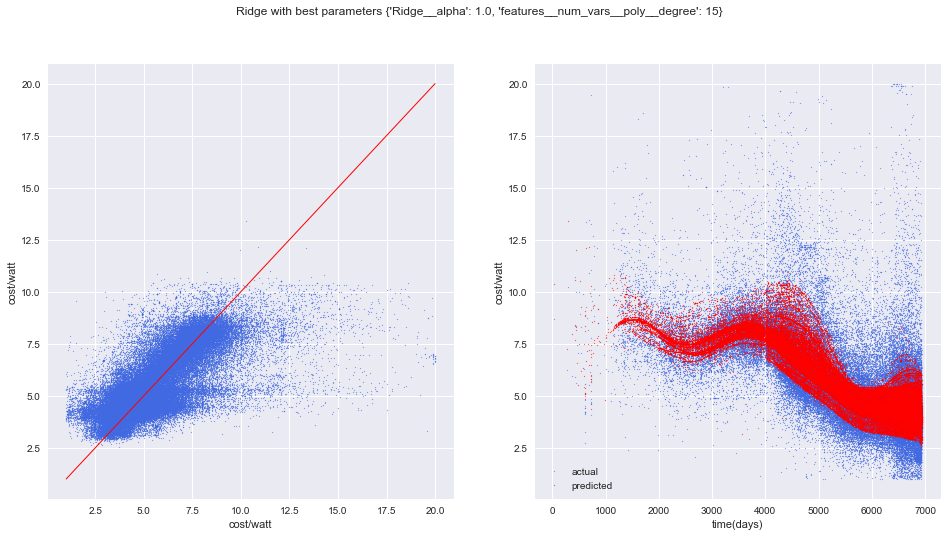

In [15]:
r2 = model.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("test R squared: {}".format(r2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
sTitle = 'Ridge with best parameters {}'
fig.suptitle(sTitle.format(gs_cv.best_params_))

ax1.scatter(y_test, model.predict(X_test), marker='.', color='royalblue', s=4, alpha=0.5);
ax1.plot(np.array([1,20]), np.array([1,20]), linewidth=1, color='red')
ax1.set_ylabel('cost/watt')
ax1.set_xlabel('cost/watt')

ax2.scatter(X_test.iloc[:, 0], y_test, marker='.', color='royalblue', s=4, alpha=0.5, label='actual')
ax2.scatter(X_test.iloc[:, 0], model.predict(X_test), marker='.', color='red', s=4, alpha=0.5, label='predicted')
ax2.set_ylabel('cost/watt')
ax2.set_xlabel('time(days)')
ax2.legend()
plt.show();

In [95]:
model.cv_results_

{'mean_fit_time': array([2.9579, 2.8152, 3.2118, 2.8722, 3.5614]),
 'mean_score_time': array([1.4469, 1.4935, 1.414 , 1.3867, 1.607 ]),
 'mean_test_RMSE': array([-1.4727, -1.4727, -1.4727, -1.4727, -1.4727]),
 'mean_test_Rsquared': array([0.5314, 0.5314, 0.5314, 0.5314, 0.5314]),
 'mean_train_RMSE': array([-1.4711, -1.4711, -1.4711, -1.4711, -1.4711]),
 'mean_train_Rsquared': array([0.5324, 0.5324, 0.5324, 0.5324, 0.5324]),
 'param_Ridge__alpha': masked_array(data=[0.6, 0.8, 1.0, 1.2, 1.4],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_features__num_vars__poly__degree': masked_array(data=[14, 14, 14, 14, 14],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'Ridge__alpha': 0.6, 'features__num_vars__poly__degree': 14},
  {'Ridge__alpha': 0.8, 'features__num_vars__poly__degree': 14},
  {'Ridge__alpha': 1.0, 'features__num_vars__poly__degree': 14},


In [17]:
def trainVsTestResults(results):
    ''' Plot test/train results for R^2 and RMSE'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    sTitle = 'mean train/test RMSE and R^2 vs ridge alpha'
    fig.suptitle(sTitle)
          
    mean_train_RMSE = results['mean_train_RMSE']
    mean_test_RMSE = results['mean_test_RMSE']
    n = len(mean_train_RMSE)
        
    ax1.plot(results['param_Ridge__alpha'].data, np.abs(mean_train_RMSE), marker='d', alpha=1, color='green', label='train');
    ax1.plot(results['param_Ridge__alpha'].data, np.abs(mean_test_RMSE), marker='*', ms=10, alpha=0.5, color='red', label='test');
    ax1.set_ylabel('RMSE')
    ax1.set_xlabel('ridge alpha')
    ax1.set_title('mean train/test RMSE vs ridge alpha')
    ax1.legend()
    
    mean_train_R2 = results['mean_train_Rsquared']
    mean_test_R2 = results['mean_test_Rsquared']
    n = len(mean_train_R2)
    
    fig.suptitle(sTitle.format(gs_cv.best_params_['features__num_vars__poly__degree']))

    ax2.plot(results['param_Ridge__alpha'].data, np.abs(mean_train_R2), marker='d', alpha=1, color='green', label='train');
    ax2.plot(results['param_Ridge__alpha'].data, np.abs(mean_test_R2), marker='*', ms=10, alpha=0.5, color='red', label='test');
    ax2.set_ylabel('R^2')
    ax2.set_xlabel('ridge alpha')
    ax2.set_title('mean train/test R2 vs ridge alpha')
    ax2.legend()
          
    r2 = gs_cv.score(X_test, y_test)
    print("Best parameters: {}".format(gs_cv.best_params_))
    print("Best R squared: {}".format(r2))

Best parameters: {'Ridge__alpha': 1.0, 'features__num_vars__poly__degree': 15}
Best R squared: 0.5341095169776686


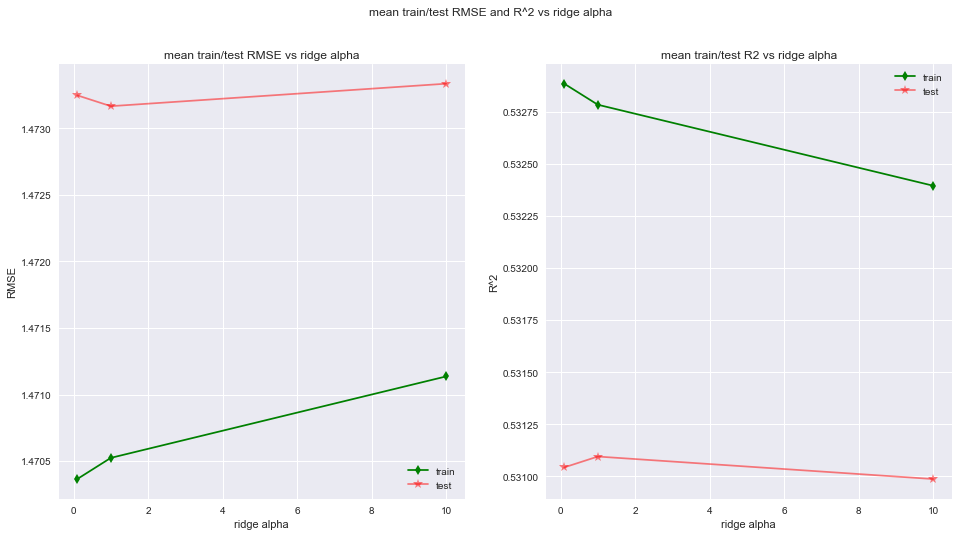

In [18]:
trainVsTestResults(model.cv_results_)

### Now tighten the noose...

In [19]:
# capture RMSE and R2
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scoring = {'Rsquared': 'r2',
           'RMSE': make_scorer(RMSE, greater_is_better=False) }

# use 100k data points for test
X = dfMod[['num_days', 'size_kw', 'state_AZ',
              'state_CA', 'state_CT', 'state_DE', 'state_FL', 'state_MA', 'state_MD',
              'state_MN', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY',
              'state_OR', 'state_PA', 'state_TX', 'state_VT', 'state_WI']]
y = dfMod[['cost_per_watt']]

# Specify the hyperparameter space.
poly_space = np.array([15])
alpha_space = np.array([0.3, 0.8, 1, 1.3, 1.8])
# Create the hyperparameter grid
param_grid = {'features__num_vars__poly__degree': poly_space,
              'Ridge__alpha': alpha_space}            

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)

# Create the GridSearchCV object: gm_cv
gs_cv = GridSearchCV(theRidgePipe, param_grid, cv=4, scoring=scoring, 
                     return_train_score=True, verbose=3, refit='Rsquared')

# Fit to the training set
model = gs_cv.fit(X_train, y_train)

# Compute and print the metrics
r2 = model.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("test R squared: {}".format(r2))

Fitting 4 folds for each of 5 candidates, totalling 20 fits
[CV] Ridge__alpha=0.3, features__num_vars__poly__degree=15 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.611815090953833e-26 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=0.3, features__num_vars__poly__degree=15, Rsquared=0.5352787626101772, RMSE=-1.460321684951321, total=   5.0s
[CV] Ridge__alpha=0.3, features__num_vars__poly__degree=15 ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.3s remaining:    0.0s
C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.4269789556454476e-26 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=0.3, features__num_vars__poly__degree=15, Rsquared=0.5255712061413198, RMSE=-1.4837231336772567, total=   5.1s
[CV] Ridge__alpha=0.3, features__num_vars__poly__degree=15 ...........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.0s remaining:    0.0s
C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.505049163679201e-26 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=0.3, features__num_vars__poly__degree=15, Rsquared=0.5320324722870127, RMSE=-1.4739346889963891, total=   5.0s
[CV] Ridge__alpha=0.3, features__num_vars__poly__degree=15 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.6682350097579875e-26 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=0.3, features__num_vars__poly__degree=15, Rsquared=0.5313968616216258, RMSE=-1.4748434894459137, total=   4.9s
[CV] Ridge__alpha=0.8, features__num_vars__poly__degree=15 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.964840242543558e-26 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=0.8, features__num_vars__poly__degree=15, Rsquared=0.5352770992732172, RMSE=-1.460324298351208, total=   4.8s
[CV] Ridge__alpha=0.8, features__num_vars__poly__degree=15 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.471943881721195e-26 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=0.8, features__num_vars__poly__degree=15, Rsquared=0.5256420636547923, RMSE=-1.4836123300550104, total=   5.1s
[CV] Ridge__alpha=0.8, features__num_vars__poly__degree=15 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.680131103144537e-26 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=0.8, features__num_vars__poly__degree=15, Rsquared=0.5321579943457586, RMSE=-1.4737370003602794, total=   5.3s
[CV] Ridge__alpha=0.8, features__num_vars__poly__degree=15 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.115293359354635e-26 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=0.8, features__num_vars__poly__degree=15, Rsquared=0.5313041408529431, RMSE=-1.4749893931403328, total=   4.8s
[CV] Ridge__alpha=1.0, features__num_vars__poly__degree=15 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.706050303179446e-26 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=1.0, features__num_vars__poly__degree=15, Rsquared=0.5352682567756096, RMSE=-1.460338191418098, total=   5.1s
[CV] Ridge__alpha=1.0, features__num_vars__poly__degree=15 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.089929852151494e-26 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=1.0, features__num_vars__poly__degree=15, Rsquared=0.5256700461628167, RMSE=-1.4835685700554233, total=   4.9s
[CV] Ridge__alpha=1.0, features__num_vars__poly__degree=15 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.350163878930671e-26 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=1.0, features__num_vars__poly__degree=15, Rsquared=0.5321655064771507, RMSE=-1.4737251684273922, total=   5.0s
[CV] Ridge__alpha=1.0, features__num_vars__poly__degree=15 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.894116699193294e-26 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=1.0, features__num_vars__poly__degree=15, Rsquared=0.5312742017870689, RMSE=-1.475036501620771, total=   5.1s
[CV] Ridge__alpha=1.3, features__num_vars__poly__degree=15 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.1317865394133282e-25 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=1.3, features__num_vars__poly__degree=15, Rsquared=0.5352542274256619, RMSE=-1.4603602336405308, total=   5.1s
[CV] Ridge__alpha=1.3, features__num_vars__poly__degree=15 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.0516908807796942e-25 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=1.3, features__num_vars__poly__degree=15, Rsquared=0.5256548594625076, RMSE=-1.4835923196950374, total=   5.0s
[CV] Ridge__alpha=1.3, features__num_vars__poly__degree=15 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.0855213042609873e-25 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=1.3, features__num_vars__poly__degree=15, Rsquared=0.5322163835193652, RMSE=-1.4736450323779529, total=   5.0s
[CV] Ridge__alpha=1.3, features__num_vars__poly__degree=15 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.1562351708951282e-25 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=1.3, features__num_vars__poly__degree=15, Rsquared=0.5312387265464567, RMSE=-1.4750923192063976, total=   5.0s
[CV] Ridge__alpha=1.8, features__num_vars__poly__degree=15 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.5670890545723003e-25 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=1.8, features__num_vars__poly__degree=15, Rsquared=0.5352278577656288, RMSE=-1.4604016634489576, total=   4.9s
[CV] Ridge__alpha=1.8, features__num_vars__poly__degree=15 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.4561873733872688e-25 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=1.8, features__num_vars__poly__degree=15, Rsquared=0.5256485691097115, RMSE=-1.4836021567180822, total=   5.0s
[CV] Ridge__alpha=1.8, features__num_vars__poly__degree=15 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.5030294982075206e-25 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=1.8, features__num_vars__poly__degree=15, Rsquared=0.5322953303328812, RMSE=-1.4735206752131556, total=   5.3s
[CV] Ridge__alpha=1.8, features__num_vars__poly__degree=15 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.6009410058547927e-25 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=1.8, features__num_vars__poly__degree=15, Rsquared=0.5311866921072574, RMSE=-1.4751741876072386, total=   5.1s


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.5min finished
C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.099928647830693e-26 / 1.1102230246251565e-16
  RuntimeWarning)


Best parameters: {'Ridge__alpha': 0.8, 'features__num_vars__poly__degree': 15}
test R squared: 0.5341188733560205


Best parameters: {'Ridge__alpha': 0.8, 'features__num_vars__poly__degree': 15}
test R squared: 0.5341188733560205


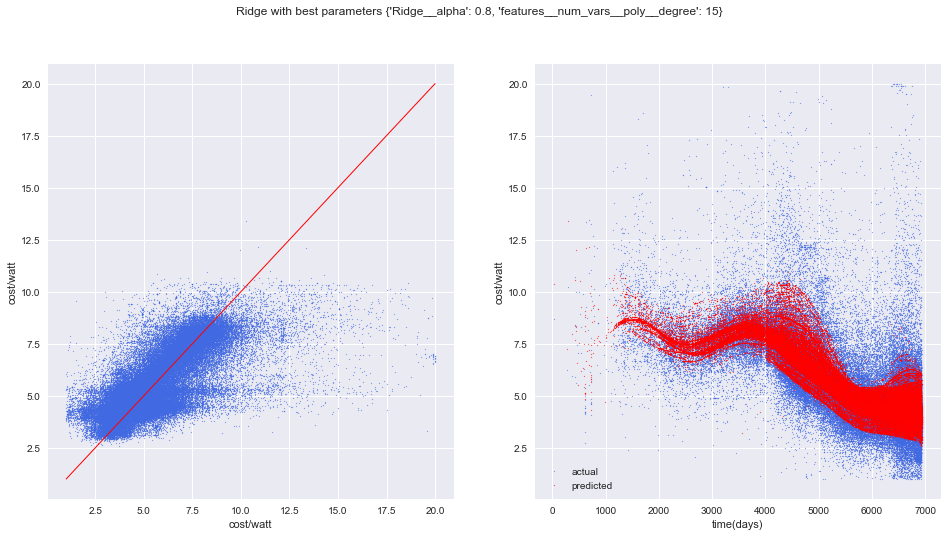

In [20]:
r2 = model.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("test R squared: {}".format(r2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
sTitle = 'Ridge with best parameters {}'
fig.suptitle(sTitle.format(gs_cv.best_params_))

ax1.scatter(y_test, model.predict(X_test), marker='.', color='royalblue', s=4, alpha=0.5);
ax1.plot(np.array([1,20]), np.array([1,20]), linewidth=1, color='red')
ax1.set_ylabel('cost/watt')
ax1.set_xlabel('cost/watt')

ax2.scatter(X_test.iloc[:, 0], y_test, marker='.', color='royalblue', s=4, alpha=0.5, label='actual')
ax2.scatter(X_test.iloc[:, 0], model.predict(X_test), marker='.', color='red', s=4, alpha=0.5, label='predicted')
ax2.set_ylabel('cost/watt')
ax2.set_xlabel('time(days)')
ax2.legend()
plt.show();